In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sourcesep.utils.compute import welch_psd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)


def stochastic_component(sampling_freq=20, n_samples=1000, spike_prob=None):
    distrib = torch.distributions.Bernoulli(spike_prob/sampling_freq)
    samples = distrib.sample((n_samples,))
    samples_log_prob = distrib.log_prob(samples)
    return samples, samples_log_prob


def get_timeseries(samples,
                   sampling_freq=20,
                   n_samples=1000,
                   decay_const=None):

    t = torch.arange(n_samples, dtype=torch.float32) / \
        sampling_freq  # in seconds
    # fixed filter_size: 5 x maximum decay constant
    filter_size = int(sampling_freq * 25)
    filter = torch.exp(-t[0:filter_size]/decay_const).reshape(1, 1, -1)
    filter_flipped = torch.flip(filter, dims=(2,))  # torch conv is cross corr

    data_time_series = samples.reshape(1, 1, -1)
    signal = F.conv1d(data_time_series, filter_flipped, padding='valid')
    shift = data_time_series.shape[2]-signal.shape[2]
    time = t[shift:]

    n_per_segment = signal.numel() // 20
    n_overlap = n_per_segment // 2
    freq, psd = welch_psd(signal=signal.squeeze(),
                          n_per_segment=n_per_segment,
                          n_overlap=n_overlap,
                          sampling_freq=sampling_freq)
    return time, signal, freq, psd


spike_prob_tgt = 0.1
decay_const_tgt = 2.0
sampling_freq = 20
n_samples = 10500


def decay_time_fn(x): return 5*torch.sigmoid(x)
def sigmoid_inv_fn(p): return torch.log(p/(1-p))
def spike_prob_fn(x): return torch.sigmoid(x)


p = torch.tensor(spike_prob_tgt + 0.3)
theta = sigmoid_inv_fn(p).detach().clone().requires_grad_(True)

p = (1/5)*torch.tensor(decay_const_tgt)
phi = sigmoid_inv_fn(p).detach().clone().requires_grad_(True)

optimizer = torch.optim.SGD([theta, phi], lr=10.)

samples_tgt, samples_log_prob_tgt = stochastic_component(sampling_freq=sampling_freq,
                                                         n_samples=n_samples,
                                                         spike_prob=spike_prob_tgt)

time_tgt, signal_tgt, freq_tgt, psd_tgt = get_timeseries(samples=samples_tgt,
                                                         sampling_freq=sampling_freq,
                                                         n_samples=n_samples,
                                                         decay_const=decay_const_tgt)

def deterministic_component(samples,
                   sampling_freq=20,
                   n_samples=1000,
                   decay_const=None):
    time_src, signal_src, freq_src, psd_src = get_timeseries(samples=samples,
                                                                sampling_freq=sampling_freq,
                                                                n_samples=n_samples,
                                                                decay_const=decay_const)
    loss = torch.sum((torch.log(psd_src) - torch.log(psd_tgt))**2)
    return time_src, signal_src, freq_src, psd_src, loss

n_steps = 10000
est_prob = [None]*n_steps
est_decay_time = [None]*n_steps
for i in range(n_steps):
    optimizer.zero_grad()

    samples_src, samples_log_prob_src = stochastic_component(sampling_freq=sampling_freq,
                                                             n_samples=n_samples,
                                                             spike_prob=spike_prob_fn(theta))

    time_src, signal_src, freq_src, psd_src, det_loss = deterministic_component(samples=samples_src,
                            sampling_freq=sampling_freq,
                            n_samples=n_samples,
                            decay_const=decay_time_fn(phi))

    loss_surrogate = torch.mean(samples_log_prob_src) * det_loss.detach() + det_loss # the expectation is over a single sample here; could be changed to a batch later
    loss_surrogate.backward()
    optimizer.step()
    est_prob[i] = spike_prob_fn(theta).item()
    est_decay_time[i] = decay_time_fn(phi).item()

    if i % 1000 == 0:
        print(f'step:{i:04d}: ' + \
              f'p_spiking={torch.sigmoid(theta).item():0.3f} [Hz] (target = {spike_prob_tgt:0.3f})  ' + \
              f't_decay={decay_time_fn(phi).item():0.3f} [s] (target={decay_const_tgt:0.2f}) ' + \
              f'loss={det_loss.item():0.6f}  ' + \
              f'loss_sfe={loss_surrogate.item():0.6f}')

        _, axes = plt.subplots(1, 2, figsize=(9, 2))
        ax = axes[0]
        ax.semilogy(psd_src.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.semilogy(psd_tgt.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
        ax.grid()

        ax = axes[1]
        ax.plot(time_src.detach().numpy().squeeze(), signal_src.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.plot(time_tgt.detach().numpy().squeeze(), signal_tgt.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Time [s]', ylabel='Amplitude')
        ax.grid()
        plt.tight_layout()
        plt.legend()
        plt.show()


step:0000:p_spiking=0.402 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=2.169104  loss_sfe=-2016.870605


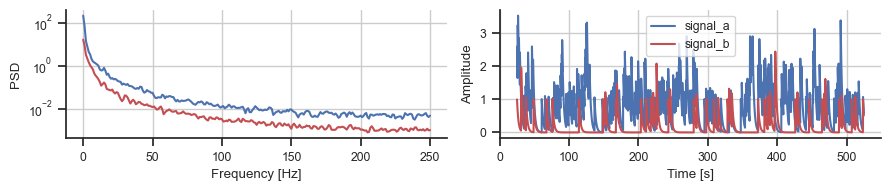

step:1000:p_spiking=0.213 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.833590  loss_sfe=-497.224274


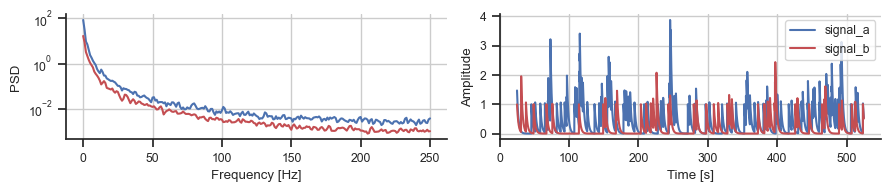

step:2000:p_spiking=0.107 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.055131  loss_sfe=-16.498323


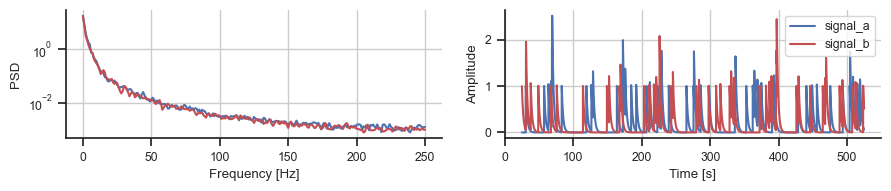

step:3000:p_spiking=0.089 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.074745  loss_sfe=-19.913076


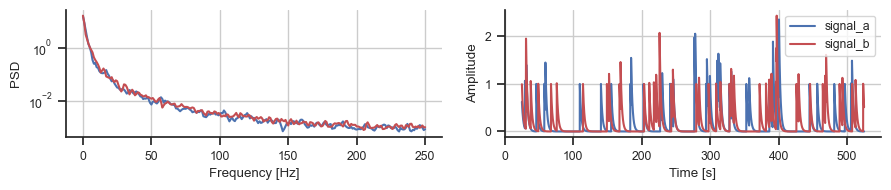

step:4000:p_spiking=0.091 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.045168  loss_sfe=-12.037390


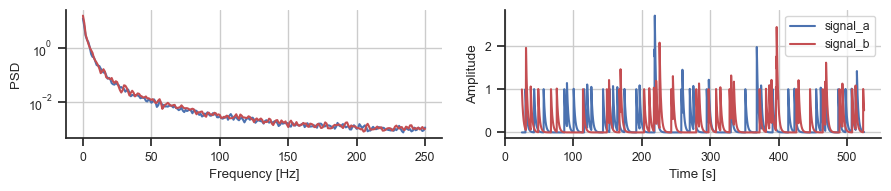

step:5000:p_spiking=0.083 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.066397  loss_sfe=-19.499971


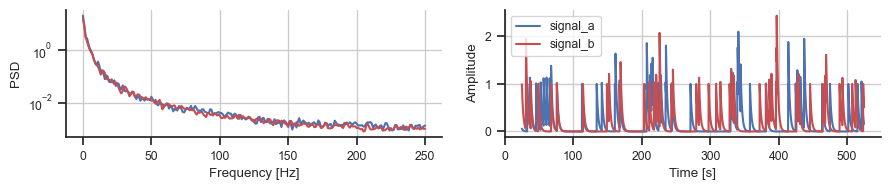

step:6000:p_spiking=0.083 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.053052  loss_sfe=-14.418133


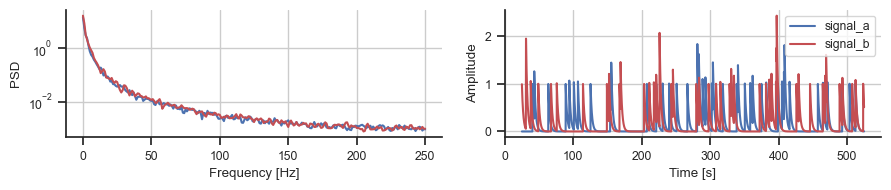

step:7000:p_spiking=0.087 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.047133  loss_sfe=-13.834696


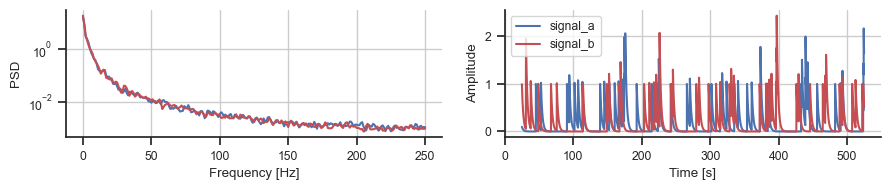

step:8000:p_spiking=0.083 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.066382  loss_sfe=-21.312923


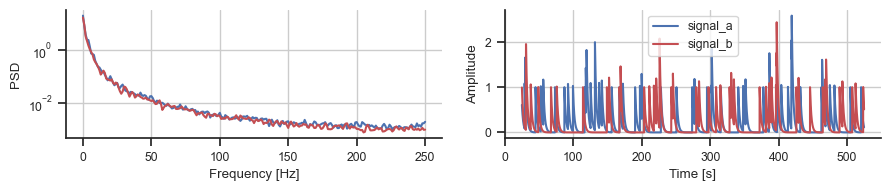

step:9000:p_spiking=0.089 [Hz] (target = 0.100)  t_decay=2.000 [s] (target=2.00) loss=0.059641  loss_sfe=-15.568070


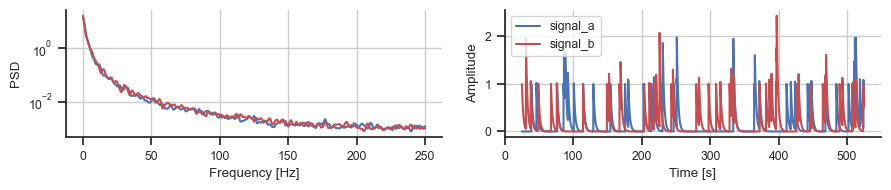

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sourcesep.utils.compute import welch_psd

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)

def make_signal_torch(sampling_frequency=20,
                n_samples=1000,
                exp_decay_constant=None,
                spike_freq=None):

    t = torch.arange(n_samples, dtype=torch.float32) / sampling_frequency  # in seconds
    #filter_size = int(exp_decay_constant * sampling_frequency * 3)
    filter_size = int(sampling_frequency * 25) # fixed filter width
    filter = torch.exp(-t[0:filter_size]/exp_decay_constant).reshape(1, 1, -1)
    filter_flipped = torch.flip(filter, dims=(2,))  # torch conv is cross corr

    distrib = torch.distributions.Bernoulli(spike_freq/sampling_frequency)
    samples = distrib.sample((n_samples,))
    samples_log_prob = distrib.log_prob(samples)
    data_time_series = samples.reshape(1, 1, -1)
    signal = F.conv1d(data_time_series, filter_flipped, padding='valid')
    shift = data_time_series.shape[2]-signal.shape[2]
    time = t[shift:]
    samples_log_prob = samples_log_prob[shift:]
    return time, signal, samples_log_prob

target_spike_prob = 0.1
target_decay_constant = 2.0
sampling_frequency = 20
n_samples=10500

decay_time = lambda x: 5*torch.sigmoid(x)
sigmoid_inv = lambda p: torch.log(p/(1-p))
p=torch.tensor(target_spike_prob + 0.3)
theta_a = sigmoid_inv(p).detach().clone().requires_grad_(True)

p = (1/5)*torch.tensor(target_decay_constant)
phi_a = sigmoid_inv(p).detach().clone().requires_grad_(False)

optimizer = torch.optim.Adam([theta_a], lr=0.01)

time_b, signal_b, log_probs_b = make_signal_torch(sampling_frequency=sampling_frequency,
                                n_samples=n_samples,
                                exp_decay_constant=target_decay_constant,
                                spike_freq=target_spike_prob)

n_steps = 10000
est_prob = [None]*n_steps
est_decay_time = [None]*n_steps
for i in range(n_steps):
    optimizer.zero_grad()

    time_a, signal_a, log_probs_a = make_signal_torch(sampling_frequency=sampling_frequency,
                                n_samples=n_samples,
                                exp_decay_constant=decay_time(phi_a),
                                spike_freq=torch.sigmoid(theta_a))


    min_length = min(signal_a.shape[2], signal_b.shape[2])
    signal_a = signal_a[:, :, :min_length]
    time_a = time_a[:min_length]
    log_probs_a = log_probs_a[:min_length]
    n_per_segment = min_length // 20
    n_overlap = n_per_segment // 2

    freqs_welch_a, psd_welch_a = welch_psd(signal=signal_a.squeeze(),
                                    n_per_segment=n_per_segment, 
                                    n_overlap=n_overlap, 
                                    sampling_freq=sampling_frequency)

    if i==0:
        # signal_b is fixed beyond the intial crop
        time_b = time_b[:min_length]
        signal_b = signal_b[:, :, :min_length]
        log_probs_b = log_probs_b[:min_length]
    
        freqs_welch_b, psd_welch_b = welch_psd(signal=signal_b.squeeze(),
                                    n_per_segment=n_per_segment, 
                                    n_overlap=n_overlap, 
                                    sampling_freq=sampling_frequency)

    #loss = (torch.sum(signal_a) - torch.sum(signal_b))**2
    loss = torch.mean((torch.log(psd_welch_a) - torch.log(psd_welch_b))**2)
    loss_sfe = torch.sum(log_probs_a * loss.detach()) #+ loss
    loss_sfe.backward()
    optimizer.step()
    est_prob[i] = torch.sigmoid(theta_a).item()
    est_decay_time[i] = decay_time(phi_a).item()

    if i % 1000 == 0:
        print(f'step:{i:04d}:' + \
              f'p_spiking={torch.sigmoid(theta_a).item():0.3f} [Hz] (target = {target_spike_prob:0.3f})  ' + \
              f't_decay={decay_time(phi_a).item():0.3f} [s] (target={target_decay_constant:0.2f}) ' + \
              f'loss={loss.item():0.6f}  ' + \
              f'loss_sfe={loss_sfe.item():0.6f}')

        _, axes = plt.subplots(1, 2, figsize=(9, 2))
        ax = axes[0]
        ax.semilogy(psd_welch_a.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.semilogy(psd_welch_b.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Frequency [Hz]', ylabel='PSD')
        ax.grid()

        ax = axes[1]
        ax.plot(time_a.detach().numpy().squeeze(), signal_a.detach().numpy().squeeze(), c='b', label='signal_a')
        ax.plot(time_b.detach().numpy().squeeze(), signal_b.detach().numpy().squeeze(), c='r', label='signal_b')
        ax.set(xlabel='Time [s]', ylabel='Amplitude')
        ax.grid()
        plt.tight_layout()
        plt.legend()
        plt.show()


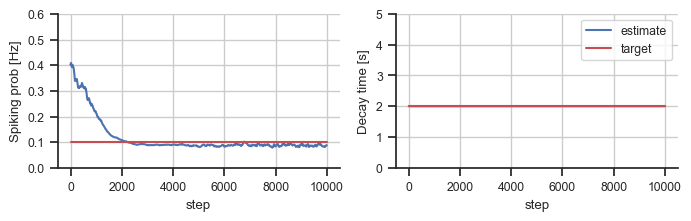

In [3]:
f, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].plot(est_prob, c='b', label='estimate')
ax[0].plot([0, len(est_prob)],[target_spike_prob,target_spike_prob], c='r',label='target')
ax[0].set(xlabel='step', ylabel='Spiking prob [Hz]', ylim=(0,0.6))
ax[0].grid()

ax[1].plot(est_decay_time, c='b', label='estimate')
ax[1].plot([0, len(est_decay_time)],[target_decay_constant,target_decay_constant], c='r',label='target')
ax[1].set(xlabel='step', ylabel='Decay time [s]', ylim=(0,5))
ax[1].grid()
plt.legend()
plt.show()
